Introduction!
=====
This notebook demonstrates one method of interacting with the [Egyptian fruit bat datasets](https://www.nature.com/articles/sdata2017143). The dataset includes ~300k vocalization samples, ~90k of which are labeled. In this notebook we are going to work with a subsection of the labeled datasets, which contains only around ~8k labeled samples. We will be trying to predict the context of an interaction between two bats -- essentially trying to answer the question: "what are these two bats doing given what they are saying?". 

Let's start out by downloading the dataset and familiarizing ourselves with the audio samples:


In [1]:
#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline

from fastai.vision.all import *
import torchaudio
import pathlib
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [2]:
dest_path = "/home/jupyter/data/"
# !wget -P {dest_path} https://archive.org/download/egyptian_fruit_bat_annotated_tiny/egyptian_fruit_bat_annotated_tiny.zip
# !7z x {dest_path}egyptian_fruit_bat_annotated_tiny.zip -o{dest_path}/ -y;

Once the data is downloaded to the destination path, let's go ahead and look at the files/folders we just downloaded:


In [3]:
!ls -a {dest_path}egyptian_fruit_bat_annotated_tiny/

.			files102  files202  files208  files214	files220
..			files103  files203  files209  files215	files221
Annotations.csv		files104  files204  files210  files216	files222
better_annotations.csv	files105  files205  files211  files217	files223
FileInfo.csv		files106  files206  files212  files218	files224
files101		files201  files207  files213  files219


Okay! So the vocalization samples are located within the sub-directories named like ```\files###```, while the annotations and file information are stored in csv format. Let's now grab all the wav files in our destination path, and listen to some bat sqeaks! 


In [4]:
path = Path("{}egyptian_fruit_bat_annotated_tiny".format(dest_path))
wav_files = [str(x) for x in path.glob("**/*") if "WAV" in str(x)]


print("Found {} squeaks!".format(len(wav_files)))
Audio(filename = wav_files[0])

Found 8224 squeaks!


Annotations!
-----
The file ```\better_annotations.csv``` inherets information stored in both the ```\Annotations.csv``` and ```\FileInfo.csv```. For each file, there is a unique ```FileID``` (found in the file info) paramter associated with the annotated data. The ```\better_annotations.csv``` joins the ```FileID``` parameter with the ```File Name``` parameter, such that we can associate each file with its unique annotation.


In [5]:
annotations_full = pd.read_csv("{}/egyptian_fruit_bat_annotated_tiny/better_annotations.csv".format(dest_path))
annotations_full.head()

,Unnamed: 0,FileID,Emitter,Addressee,Context,Emitter pre-vocalization action,Addressee pre-vocalization action,Emitter post-vocalization action,Addressee post-vocalization action,Start sample,End sample,File name,File folder
0,0,7,118,0,9,2,2,3,3,1,336720,120601002132055008.WAV,files101
1,1,11,0,0,11,0,0,0,0,1,787280,120601002344862013.WAV,files101
2,2,12,118,0,12,2,2,3,3,1,566096,120601003734539035.WAV,files101
3,3,15,0,0,12,0,0,0,0,1,402256,120601004402612052.WAV,files101
4,4,20,0,0,12,0,0,0,0,1,394064,120601005147813084.WAV,files101


Most of the annotations for each file are pretty self-explanatory, but if you are interested in getting more information about the true description of each label, you can view the meta-data [here](https://ia801505.us.archive.org/view_archive.php?archive=/15/items/egyptian_fruit_bat_annotated/egyptian_fruit_bat_annotated.zip&file=Metadata.pdf). We are also going to throw out three categories: "general", "unknown" and "landing", because for these cases, there is either not enough data (~8 samples across the full annotated set) or the label is too non-specific to be meaningful. 

Now let's simplify the ```annotations``` dataframe even further, by mapping the ```Context``` parameter to a more verbose description, and by filling out the ```File path``` parameter:


In [6]:
context_dict = {0:"unknown", 1:"separation", 2:"biting", 
                3:"feeding", 4:"fighting", 5:"grooming", 
                6:"isolation", 7:"kissing", 8:"landing", 
                9:"mating protest", 10:"threat-like", 
                11:"general", 12:"sleeping"}

annotations = annotations_full.loc[:,["File name", "File folder", "Context"]]
annotations["Context desc."] = [context_dict[x] for x in annotations["Context"]]
annotations["File path"] = ["{}/{}/{}".format(str(path),
                                              str(annotations['File folder'][i]), 
                                              str(annotations['File name'][i])) for i in annotations.index]

annotations = annotations[annotations["File path"].isin(wav_files)]
annotations = annotations.drop_duplicates(subset = ['File path'])

annotations = annotations.loc[annotations['Context desc.'] != 'landing']
annotations = annotations.loc[annotations['Context desc.'] != 'unknown']
annotations = annotations.loc[annotations['Context desc.'] != 'general']

annotations.head()

,File name,File folder,Context,Context desc.,File path
6,120601011044407132.WAV,files101,1,separation,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files101/120601011044407132.WAV
7,120601011047196133.WAV,files101,1,separation,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files101/120601011047196133.WAV
23,120601041134496318.WAV,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files101/120601041134496318.WAV
54,120601163203025371.WAV,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files101/120601163203025371.WAV
118,120603011026138518.WAV,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files101/120603011026138518.WAV


<AxesSubplot:title={'center':'Class Label Distribution'}, ylabel='count'>

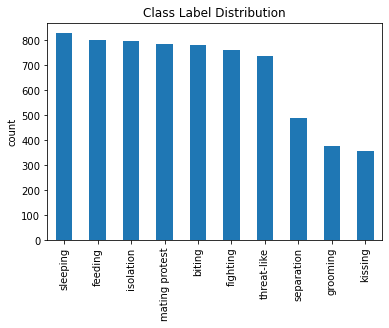

In [7]:
annotations['Context desc.'].value_counts().plot(kind = 'bar', title = "Class Label Distribution", ylabel = "count") 

Audio to Image:
----

There are a million and one ways to represent a sound file as an image, but today we'll use the [CQ](https://en.wikipedia.org/wiki/Constant-Q_transform) transform! The parameters for the following function were computed and discussed in the notebook: `bat_spectrogram_tuner`. So the CQ transform essentially transforms the audio sample into a greyscale image, but the nice thing is that `resnet` models can handle three channels of color! We'll us these added dimensions to our advantage by segmenting different points in time of the spectrogram into different color channels! (the red channel will cover the first third and so on) The function `gs_to_bts_rgb` (greyscale to block-time-segmented rgb) takes an mxn matrix and transforms it into a mxnx3 matrix, where "time" is chunked into the three new dimensions (equal thirds). The function `gs_to_rbts_rgb` does nearly the same thing, but some randomness is introduced (partially equal thirds).


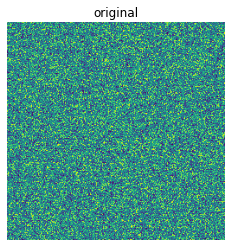

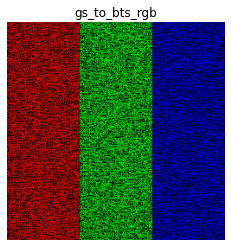

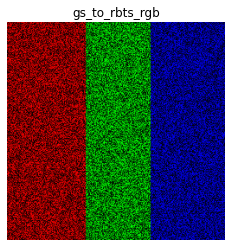

In [8]:
def gs_to_bts_rgb(x):
    #grey scale to block-time-segmented rgb
    one_block = np.ones((x.shape[0], int(x.shape[1]/3)))
    zero_block = np.zeros((x.shape[0], int(x.shape[1]/3)))
    
    mask0 = np.block([one_block, zero_block, zero_block])
    mask1 = np.block([zero_block, one_block, zero_block])
    mask2 = np.block([zero_block, zero_block, one_block])

    new_x = np.dstack((np.multiply(x, mask0),
                       np.multiply(x, mask1), 
                       np.multiply(x, mask2)))
    
    return new_x

def gs_to_rbts_rgb(x, variance = 0.095):
    #grey scale to random block-time-segmented rgb
    t = np.random.uniform(0.333 - variance, 0.333 + variance, 3)
    t = np.round(t/sum(t)*x.shape[1]).astype(np.uint8)
    t[2] -= sum(t) - x.shape[1] #correcting rounding error
    
    block_0 = (np.ones((x.shape[0], t[0]))).astype(np.bool)
    block_1 = (np.ones((x.shape[0], t[1]))).astype(np.bool)
    block_2 = (np.ones((x.shape[0], t[2]))).astype(np.bool)
    
    mask0 = np.block([block_0.astype(np.uint8), 
                      np.invert(block_1).astype(np.uint8), 
                      np.invert(block_2).astype(np.uint8)])
    
    mask1 = np.block([np.invert(block_0).astype(np.uint8),
                      block_1.astype(np.uint8),
                      np.invert(block_2).astype(np.uint8)])
    
    mask2 = np.block([np.invert(block_0).astype(np.uint8),
                      np.invert(block_1).astype(np.uint8),
                      block_2.astype(np.uint8)])
    
    new_x = np.dstack((np.multiply(x, mask0),
                       np.multiply(x, mask1), 
                       np.multiply(x, mask2)))
    
    return new_x

test_im = np.random.rand(252, 252)
plt.title("original")
plt.imshow(test_im)
plt.axis("off")
plt.show()

plt.title("gs_to_bts_rgb")
plt.imshow(gs_to_bts_rgb(test_im))
plt.axis("off")
plt.show()

plt.title("gs_to_rbts_rgb")
plt.imshow(gs_to_rbts_rgb(test_im))
plt.axis("off")
plt.show()


Just a quick comment on the rainbow-ifying of signals; I believe that by allocating different points in time to different colors we are forcing the model to treat different visual features differently should they occur in different color channels. In this way, the model will hopefully treat the information expressed in the audio in less of an 'in-batch' way, and will treat distinct points/regions in time differently (even though perhaps not chronologically).

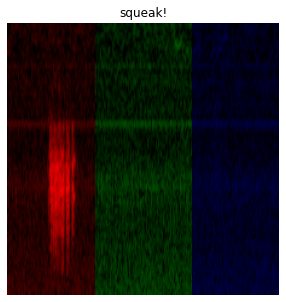

In [9]:
from skimage.transform import resize

def get_cqt(path, 
            final_transform = gs_to_rbts_rgb,
            hop_length = 1024,
            n_bins = 90, 
            fmin = "C5"):
    
    x, rate = librosa.load(path, 
                           mono = True,
                           sr = None,
                           dtype = np.float32)

    spec = librosa.cqt(x,
                       sr = rate, 
                       fmin = librosa.note_to_hz(fmin),
                       hop_length=hop_length,
                       n_bins = n_bins)
    
    
    spec = librosa.amplitude_to_db(np.abs(spec), ref = np.max)
    spec = resize(spec, (225, 225))
    
    #spec = (spec - np.max(spec))*255
    spec = 255*(spec - np.min(spec))/(np.max(spec) - np.min(spec))
    
    spec = final_transform(spec)
    return spec.astype(np.uint8)


x = get_cqt(wav_files[0])
plt.figure(figsize = (5, 5))
plt.imshow(x)
plt.title("squeak!")
plt.axis("off")
plt.show()


So our `get_x()` function is looking pretty good! Now all we need to do is create faithful `get_y()` and `get_items()` functions and we are almost done! The `get_y()` simply just looks up the annotation for a given file within the `annotations` dataframe. For the `get_items()` function, it is important to make sure that we have labels for all the files we have, and vice versa. So we take the intersection between all of the files in `wav_files` and the unique files in `annotations['File path']`:


In [10]:
def get_y(p, annotations = annotations):
    return annotations.loc[annotations['File path'] == p]['Context desc.'].values[0]


# with get_items we want to make sure we have both the file and the label:
def get_items(p, annotations = annotations):
    temp_wav_files = [str(x) for x in get_files(p) if "WAV" in str(x)] 
    return annotations.loc[annotations['File path'].isin(temp_wav_files)]['File path'].values


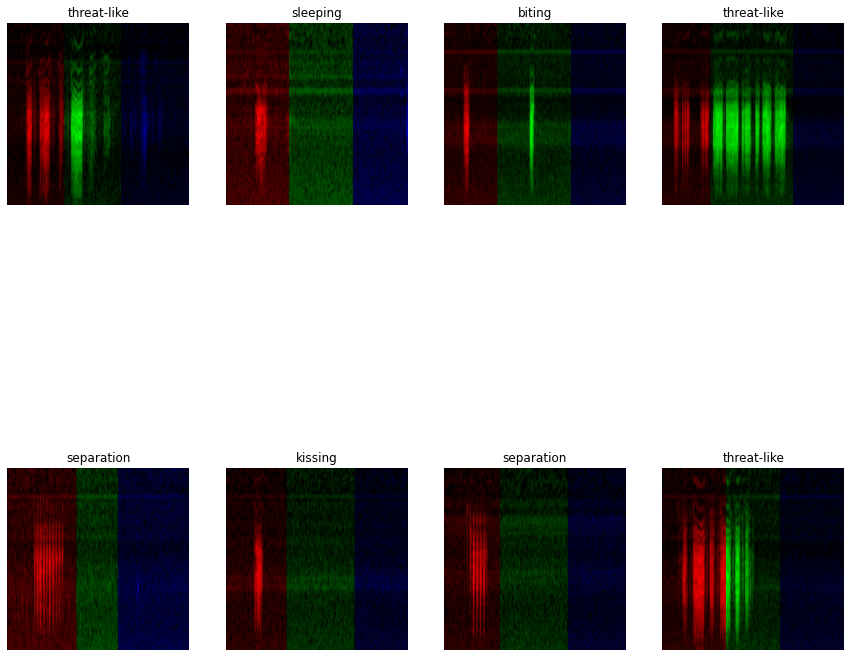

In [11]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock), 
               get_items = get_items, 
               get_x = get_cqt, 
               get_y = get_y, 
               splitter = RandomSplitter(seed = 42))

dls = db.dataloaders(path, 
                     bs = 8)

dls.show_batch(figsize = (15, 15))

In [12]:
learner = cnn_learner(dls, 
                      resnet34, 
                      metrics=accuracy)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=6.309573450380412e-07)

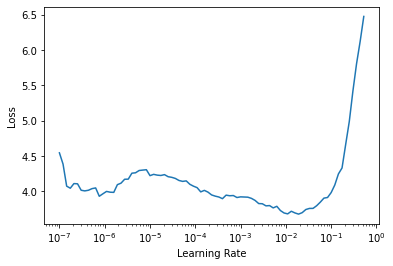

In [13]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.796558,1.923073,0.383185,18:00
1,2.088560,1.736914,0.408482,18:00
2,1.818396,1.689284,0.409226,18:00
3,1.787554,1.512408,0.461310,17:59
4,1.598815,1.438904,0.500000,17:59
5,1.526121,1.350828,0.514137,17:59
6,1.387305,1.302025,0.552827,18:02
7,1.298446,1.261312,0.552083,18:07
8,1.164370,1.241779,0.561012,18:06
9,1.198718,1.248474,0.559524,18:03


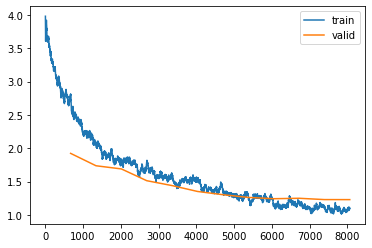

In [15]:
learner.fit_one_cycle(12, 0.002)
learner.save("resnet34_efb")
learner.recorder.plot_loss()   

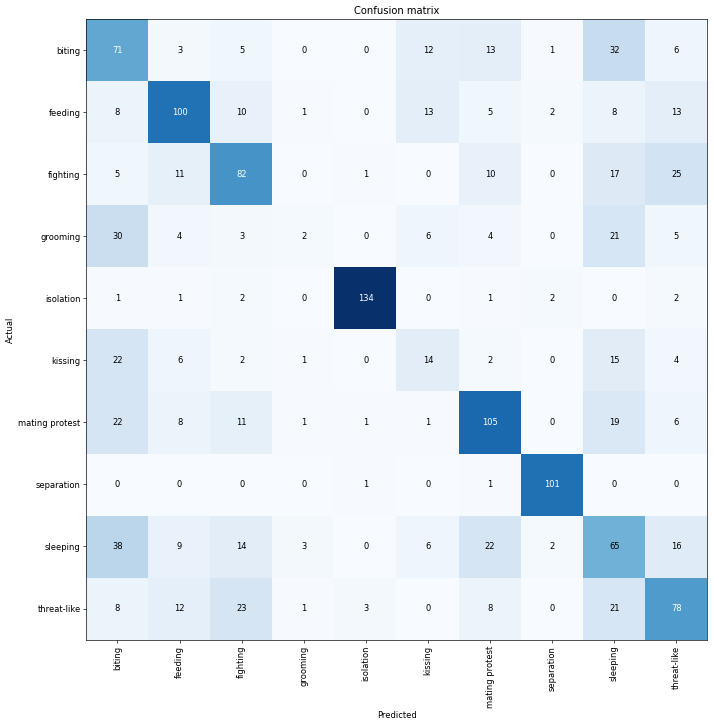

In [16]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
most_confused = interp.most_confused(min_val=10)
interp.print_classification_report()

                precision    recall  f1-score   support

        biting       0.35      0.50      0.41       143
       feeding       0.65      0.62      0.64       160
      fighting       0.54      0.54      0.54       151
      grooming       0.22      0.03      0.05        75
     isolation       0.96      0.94      0.95       143
       kissing       0.27      0.21      0.24        66
mating protest       0.61      0.60      0.61       174
    separation       0.94      0.98      0.96       103
      sleeping       0.33      0.37      0.35       175
   threat-like       0.50      0.51      0.50       154

      accuracy                           0.56      1344
     macro avg       0.54      0.53      0.52      1344
  weighted avg       0.55      0.56      0.55      1344



Oh well! Not as good as we could hope for :( Let's now look at how the model performs on samples that were labeled as 'unknown', just to see how the model compares to humans who had access to video samples of the iteractions:

In [ ]:
from functools import partial

unknown_annot = annotations_full.loc[:,["File name", "File folder", "Context"]]
unknown_annot["Context desc."] = [context_dict[x] for x in unknown_annot["Context"]]
unknown_annot = unknown_annot[unknown_annot["Context desc."] == "unknown"]
unknown_annot["File path"] = ["{}/{}/{}".format(str(path),
                                                str(unknown_annot['File folder'][i]), 
                                                str(unknown_annot['File name'][i])) for i in unknown_annot.index]

#updating the default parameters of get_y() and get_items()
u_get_items = partial(get_items, annotations = unknown_annot)
u_get_y = partial(get_y, annotations = unknown_annot)

u_dls = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                  get_items = u_get_items, 
                  get_x = get_cqt, 
                  get_y = u_get_y).dataloaders(path)

model = learner.load("resnet34_efb").model
model.eval();


In [ ]:
from tqdm import trange
from scipy.special import softmax

preds = []
batch = next(iter(u_dls))

for _ in trange(5): #probably not the best way of doing this !
    try:
        sample = next(iter(batch))
        ims, _ = sample #labels are bogus for what we are doing here
        p = softmax(model(ims).detach().numpy(), axis = 1)
        preds.append(np.argmax(p, axis = 1))
    except:
        pass

In [ ]:
context_preds = [context_dict[int(p)] for p in np.array(preds).flatten()]
plt.hist(context_preds); 

Huh! I think something is going wrong here, I'll get back to this later! 